In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pycbc import waveform
from astropy import constants
from astropy import units as u

In [2]:
def analytic_remaining_time(r0, M1, M2):
    M = M1 + M2
    mu = M1 * M2 / M
    return 5 * np.power(constants.c, 5) * np.power(r0, 4) / (256 * np.power(constants.G, 3) * mu * np.power(M, 2))

def analytic_radius(t, M1, M2):
    M = M1 + M2
    mu = M1 * M2 / M
    alpha = 5 * np.power(constants.c, 5) / (256 * np.power(constants.G, 3))
    return np.power(-mu * np.power(M, 2) / alpha * t, 1/4)

def analytic_radial_freq(t, M1, M2):
    M = M1 + M2
    mu = M1 * M2 / M
    alpha = 5 * np.power(constants.c, 5) / (256 * np.power(constants.G, 3))
    return np.sqrt(constants.G * M) * np.power(-mu * np.power(M, 2) * t / alpha, -3/8)

def analytic_phase(t, M1, M2):
    M = M1 + M2
    mu = M1 * M2 / M
    alpha = 5 * np.power(constants.c, 5) / (256 * np.power(constants.G, 3))
    orbit_phase = -(8 / 5) * np.sqrt(constants.G * M) * np.power(mu * np.power(M, 2) / alpha, -3/8) * np.power(-t, 5/8)
    return 2 * orbit_phase # waveform frequency and phase are double the orbit frequency and phase

def analytic_freq(t, M1, M2):
    return (1 / (2*np.pi)) * 2 * analytic_radial_freq(t, M1, M2)

def analytic_power(t, M1, M2):
    M = M1 + M2
    mu = M1 * M2 / M
    alpha = 5 * np.power(constants.c, 5) / (256 * np.power(constants.G, 3))
#     return (1 / (8 * alpha)) * constants.G * np.power(mu, 2) * np.power(M, 3) \
#                 * np.power(- mu * np.power(M, 2) * t / alpha, -5/4)
    return 32 * constants.G * np.power(mu, 2) / (5 * np.power(constants.c, 5)) \
                * np.power(analytic_radius(t, M1, M2), 4) \
                * np.power(analytic_radial_freq(t, M1, M2), 6)

def analytic_amplitude(t, M1, M2, distance=1*1000000*constants.pc):
    """
    source: http://www.physics.usu.edu/Wheeler/GenRel2013/Notes/GravitationalWaves.pdf
    """
    M_c = np.power(M1 * M2, 3/5) / np.power(M1 + M2, 1/5)
    return 4 * constants.G / np.power(constants.c, 2) * M_c / distance * \
                np.power(constants.G / np.power(constants.c, 3) * np.pi * analytic_freq(t, M1, M2) * M_c, 2/3)

In [3]:
def normalize_phase(phase_series):
    return phase_series - phase_series.at_time(0)

In [4]:
r = 1.0
masses = list(range(20, 150, 10))
polarizations = [] # (hp, hc)
for m in tqdm(masses):
    M1 = m
    M2 = r*M1
    hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                                    mass1=M1,
                                    mass2=M2,
                                    delta_t=1e-3,
                                    f_lower=1.5)
    polarizations.append((hp, hc))

  0%|          | 0/13 [00:00<?, ?it/s]

/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


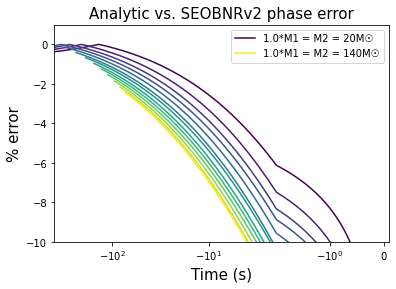

In [5]:
pct_errors = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    phase = normalize_phase(phase)
    phase_analytic = analytic_phase(phase.sample_times*u.s, M1*constants.M_sun, M2*constants.M_sun)
    pct_error = 100 * (np.abs(phase - phase_analytic) / phase)
    pct_errors.append(pct_error)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(pct_errors[i].sample_times, pct_errors[i], color=colors[i], label=label)


plt.title("Analytic vs. SEOBNRv2 phase error", fontsize=15)
plt.ylabel("% error", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.xscale('symlog')
plt.xlim(-400, 0.1)
plt.ylim(-10, 1)
plt.legend()

/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


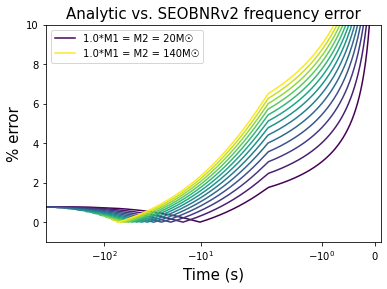

In [6]:
pct_errors = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    frequency = waveform.utils.frequency_from_polarizations(hp, hc)
    frequency_analytic = analytic_freq(frequency.sample_times*u.s, M1*constants.M_sun, M2*constants.M_sun).value
    pct_error = 100 * (np.abs(frequency - frequency_analytic) / frequency)
    pct_errors.append(pct_error)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(pct_errors[i].sample_times, pct_errors[i], color=colors[i], label=label)


plt.title("Analytic vs. SEOBNRv2 frequency error", fontsize=15)
plt.ylabel("% error", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.xscale('symlog')
plt.xlim(-400, 0.1)
plt.ylim(-1, 10)
plt.legend()

/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


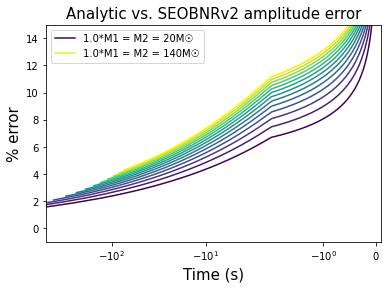

In [7]:
pct_errors = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    amplitude = waveform.utils.amplitude_from_polarizations(hp, hc)
    amplitude_analytic = analytic_amplitude(amplitude.sample_times*u.s, M1*constants.M_sun, M2*constants.M_sun).value
    pct_error = 100 * (np.abs(amplitude - amplitude_analytic) / amplitude)
    pct_errors.append(pct_error)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(pct_errors[i].sample_times, pct_errors[i], color=colors[i], label=label)


plt.title("Analytic vs. SEOBNRv2 amplitude error", fontsize=15)
plt.ylabel("% error", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.xscale('symlog')
plt.xlim(-500, 0.1)
plt.ylim(-1, 15)
plt.legend()

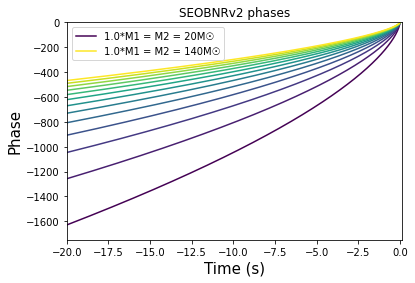

In [8]:
phases = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    phase = normalize_phase(phase)
    phases.append(phase)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(phases[i].sample_times, phases[i], color=colors[i], label=label)


plt.title("SEOBNRv2 phases", fontsize=12)
plt.ylabel("Phase", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-20, 0.1)
plt.ylim(-1750, 1)
plt.legend()

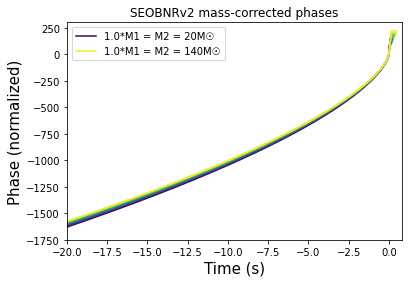

In [9]:
phases = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    phase = normalize_phase(phase)
    gamma = m / masses[0]
    phase /= np.power(gamma, -5/8)
    phases.append(phase)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(phases[i].sample_times, phases[i], color=colors[i], label=label)


plt.title("SEOBNRv2 mass-corrected phases", fontsize=12)
plt.ylabel("Phase (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-20, 0.8)
plt.ylim(-1750, 300)
plt.legend()

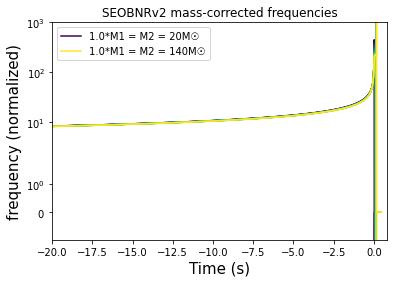

In [10]:
frequencies = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    frequency = waveform.utils.frequency_from_polarizations(hp, hc)
#     frequency = normalize_frequency(frequency)
    gamma = m / masses[0]
    frequency /= np.power(gamma, -5/8)
    frequencies.append(frequency)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(frequencies[i].sample_times, frequencies[i], color=colors[i], label=label)


plt.title("SEOBNRv2 mass-corrected frequencies", fontsize=12)
plt.ylabel("frequency (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
plt.yscale('symlog')
plt.xlim(-20, 0.8)
plt.ylim(-1, 1000)
plt.legend()

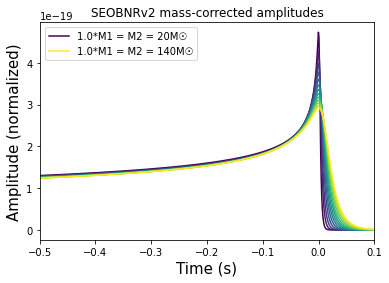

In [11]:
amplitudes = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    amplitude = waveform.utils.amplitude_from_polarizations(hp, hc)
#     amplitude = normalize_amplitude(amplitude)
    gamma = m / masses[0]
    amplitude /= np.power(gamma, 5/4)
    amplitudes.append(amplitude)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(amplitudes[i].sample_times, amplitudes[i], color=colors[i], label=label)


plt.title("SEOBNRv2 mass-corrected amplitudes", fontsize=12)
plt.ylabel("Amplitude (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-0.5, 0.1)
# plt.ylim(-1, 1000)
plt.legend()

## Let's do all these with EOBNRv2

In [12]:
r = 1.0
masses = list(range(20, 150, 10))
polarizations = [] # (hp, hc)
for m in tqdm(masses):
    M1 = m
    M2 = r*M1
    hp, hc = waveform.get_td_waveform(approximant='EOBNRv2',
                                    mass1=M1,
                                    mass2=M2,
                                    delta_t=1e-3,
                                    f_lower=1.5)
    polarizations.append((hp, hc))

  0%|          | 0/13 [00:00<?, ?it/s]

/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


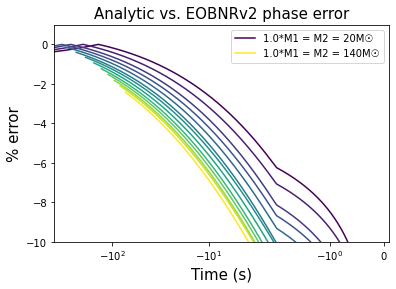

In [13]:
pct_errors = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    phase = normalize_phase(phase)
    phase_analytic = analytic_phase(phase.sample_times*u.s, M1*constants.M_sun, M2*constants.M_sun)
    pct_error = 100 * (np.abs(phase - phase_analytic) / phase)
    pct_errors.append(pct_error)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(pct_errors[i].sample_times, pct_errors[i], color=colors[i], label=label)


plt.title("Analytic vs. EOBNRv2 phase error", fontsize=15)
plt.ylabel("% error", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.xscale('symlog')
plt.xlim(-400, 0.1)
plt.ylim(-10, 1)
plt.legend()

/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


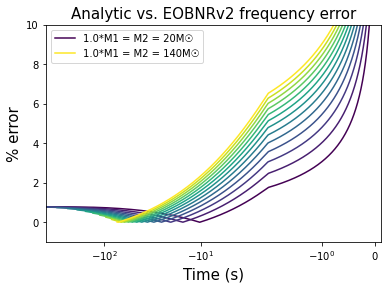

In [14]:
pct_errors = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    frequency = waveform.utils.frequency_from_polarizations(hp, hc)
    frequency_analytic = analytic_freq(frequency.sample_times*u.s, M1*constants.M_sun, M2*constants.M_sun).value
    pct_error = 100 * (np.abs(frequency - frequency_analytic) / frequency)
    pct_errors.append(pct_error)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(pct_errors[i].sample_times, pct_errors[i], color=colors[i], label=label)


plt.title("Analytic vs. EOBNRv2 frequency error", fontsize=15)
plt.ylabel("% error", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.xscale('symlog')
plt.xlim(-400, 0.1)
plt.ylim(-1, 10)
plt.legend()

/home/eric/miniconda3/envs/chirps/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


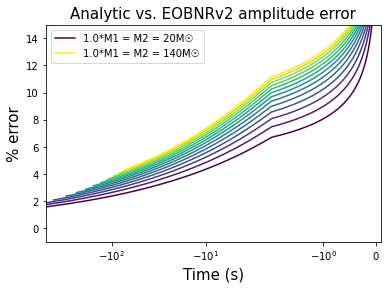

In [15]:
pct_errors = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    amplitude = waveform.utils.amplitude_from_polarizations(hp, hc)
    amplitude_analytic = analytic_amplitude(amplitude.sample_times*u.s, M1*constants.M_sun, M2*constants.M_sun).value
    pct_error = 100 * (np.abs(amplitude - amplitude_analytic) / amplitude)
    pct_errors.append(pct_error)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(pct_errors[i].sample_times, pct_errors[i], color=colors[i], label=label)


plt.title("Analytic vs. EOBNRv2 amplitude error", fontsize=15)
plt.ylabel("% error", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.xscale('symlog')
plt.xlim(-500, 0.1)
plt.ylim(-1, 15)
plt.legend()

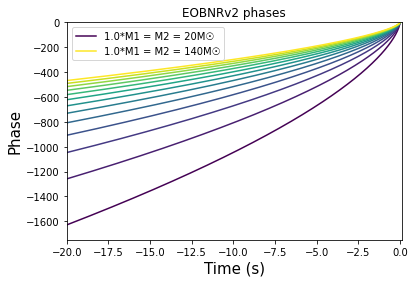

In [16]:
phases = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    phase = normalize_phase(phase)
    phases.append(phase)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(phases[i].sample_times, phases[i], color=colors[i], label=label)


plt.title("EOBNRv2 phases", fontsize=12)
plt.ylabel("Phase", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-20, 0.1)
plt.ylim(-1750, 1)
plt.legend()

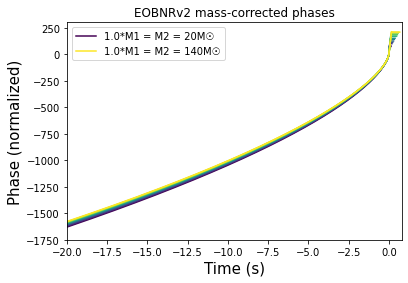

In [17]:
phases = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    phase = normalize_phase(phase)
    gamma = m / masses[0]
    phase /= np.power(gamma, -5/8)
    phases.append(phase)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(phases[i].sample_times, phases[i], color=colors[i], label=label)


plt.title("EOBNRv2 mass-corrected phases", fontsize=12)
plt.ylabel("Phase (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-20, 0.8)
plt.ylim(-1750, 300)
plt.legend()

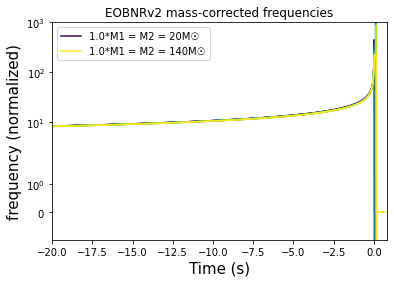

In [18]:
frequencies = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    frequency = waveform.utils.frequency_from_polarizations(hp, hc)
#     frequency = normalize_frequency(frequency)
    gamma = m / masses[0]
    frequency /= np.power(gamma, -5/8)
    frequencies.append(frequency)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(frequencies[i].sample_times, frequencies[i], color=colors[i], label=label)


plt.title("EOBNRv2 mass-corrected frequencies", fontsize=12)
plt.ylabel("frequency (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
plt.yscale('symlog')
plt.xlim(-20, 0.8)
plt.ylim(-1, 1000)
plt.legend()

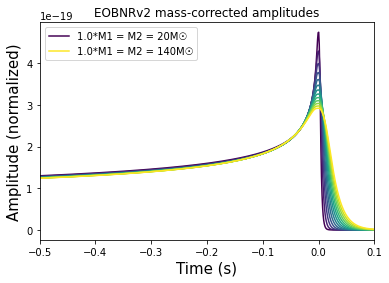

In [19]:
amplitudes = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    amplitude = waveform.utils.amplitude_from_polarizations(hp, hc)
#     amplitude = normalize_amplitude(amplitude)
    gamma = m / masses[0]
    amplitude /= np.power(gamma, 5/4)
    amplitudes.append(amplitude)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(amplitudes[i].sample_times, amplitudes[i], color=colors[i], label=label)


plt.title("EOBNRv2 mass-corrected amplitudes", fontsize=12)
plt.ylabel("Amplitude (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-0.5, 0.1)
# plt.ylim(-1, 1000)
plt.legend()

## Let's just brute force a stretch and scale to see if we can get the amplitude curves to collapse

In [47]:
amp1 = amplitudes[0]
amp2 = amplitudes[4]

(-1.0, 0.4)

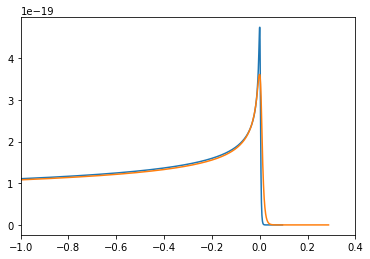

In [48]:
plt.plot(amp1.sample_times, amp1)
plt.plot(amp2.sample_times, amp2)
plt.xlim(-1, 0.4)

(-0.3, 0.3)

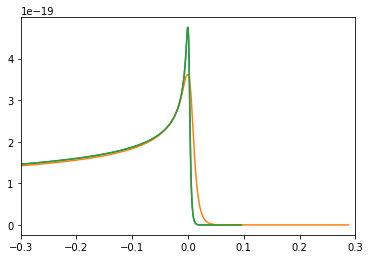

In [50]:
amp3 = amp2.copy()
scale = 3.0
amp3_sample_times = amp3.sample_times / scale
amp3 = amp3 * np.power(scale, 1/4)

plt.plot(amp1.sample_times, amp1)
plt.plot(amp2.sample_times, amp2)
plt.plot(amp3_sample_times, amp3)
plt.xlim(-0.3, 0.3)

### Okay success! We can compress time by the mass factor and then scale amplitude by the same mass factor

In [64]:
r = 1.0
masses = list(range(20, 150, 10))
polarizations = [] # (hp, hc)
for m in tqdm(masses):
    M1 = m
    M2 = r*M1
    hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                                    mass1=M1,
                                    mass2=M2,
                                    delta_t=1e-3,
                                    f_lower=3.0)
    polarizations.append((hp, hc))

  0%|          | 0/13 [00:00<?, ?it/s]

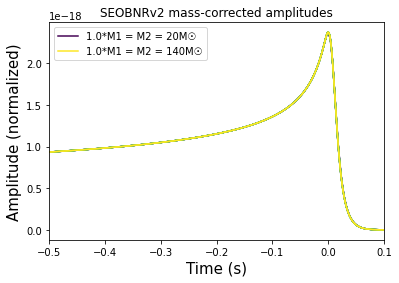

In [65]:
amplitudes = []
times = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    amplitude = waveform.utils.amplitude_from_polarizations(hp, hc)
    gamma = m / 100
    sample_times = amplitude.sample_times
    sample_times /= gamma
    amplitude /= gamma
    times.append(sample_times)
    amplitudes.append(amplitude)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(times[i], amplitudes[i], color=colors[i], label=label)


plt.title("SEOBNRv2 mass-corrected amplitudes", fontsize=12)
plt.ylabel("Amplitude (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-0.5, 0.1)
# plt.ylim(-1, 1000)
plt.legend()

In [66]:
r = 3.0
masses = list(range(20, 150, 10))
polarizations = [] # (hp, hc)
for m in tqdm(masses):
    M1 = m
    M2 = r*M1
    hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                                    mass1=M1,
                                    mass2=M2,
                                    delta_t=1e-3,
                                    f_lower=3.0)
    polarizations.append((hp, hc))

  0%|          | 0/13 [00:00<?, ?it/s]

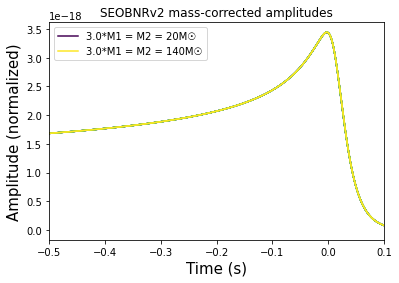

In [67]:
amplitudes = []
times = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    amplitude = waveform.utils.amplitude_from_polarizations(hp, hc)
    gamma = m / 100
    sample_times = amplitude.sample_times
    sample_times /= gamma
    amplitude /= gamma
    times.append(sample_times)
    amplitudes.append(amplitude)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(times[i], amplitudes[i], color=colors[i], label=label)


plt.title("SEOBNRv2 mass-corrected amplitudes", fontsize=12)
plt.ylabel("Amplitude (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-0.5, 0.1)
# plt.ylim(-1, 1000)
plt.legend()

In [4]:
r = 0.8
masses = list(range(20, 150, 10))
polarizations = [] # (hp, hc)
for m in tqdm(masses):
    M1 = m
    M2 = r*M1
    hp, hc = waveform.get_td_waveform(approximant='SEOBNRv2',
                                    mass1=M1,
                                    mass2=M2,
                                    delta_t=1e-3,
                                    f_lower=3.0)
    polarizations.append((hp, hc))

  0%|          | 0/13 [00:00<?, ?it/s]

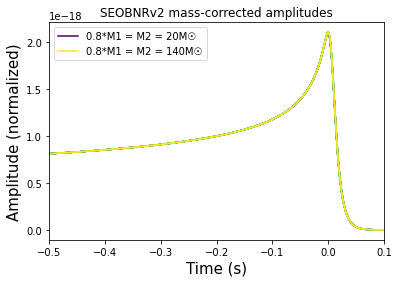

In [5]:
amplitudes = []
times = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    amplitude = waveform.utils.amplitude_from_polarizations(hp, hc)
    gamma = m / 100
    sample_times = amplitude.sample_times
    sample_times /= gamma
    amplitude /= gamma
    times.append(sample_times)
    amplitudes.append(amplitude)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(times[i], amplitudes[i], color=colors[i], label=label)


plt.title("SEOBNRv2 mass-corrected amplitudes", fontsize=12)
plt.ylabel("Amplitude (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-0.5, 0.1)
# plt.ylim(-1, 1000)
plt.legend()

In [6]:
def normalize_phase(sample_times, phases):
    assert len(sample_times) == len(phases)
    index_at_zero = len(sample_times) * (1 - sample_times[-1] / (sample_times[-1] - sample_times[0]))
    index_at_zero = int(index_at_zero) - 1
    phase_at_zero = phases[index_at_zero]
    return phases - phase_at_zero

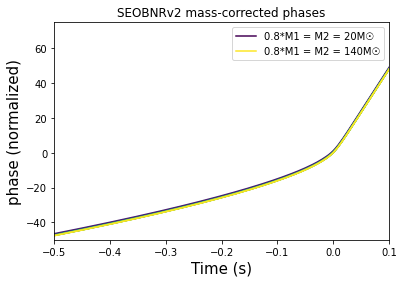

In [9]:
phases = []
times = []
for i, m in enumerate(masses):
    M1 = m
    M2 = r*M1
    hp, hc = polarizations[i]
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    sample_times = phase.sample_times
    phase = normalize_phase(sample_times, phase)
    gamma = min(M1, M2) / 100
    sample_times /= gamma
#     phase *= np.power(gamma, 13/8)
    times.append(sample_times)
    phases.append(phase)

colors = plt.cm.viridis(np.linspace(0, 1, len(masses)))
for i, m in enumerate(masses):
    if i == 0 or i == len(masses) - 1:
        label = f"{r}*M1 = M2 = {m}M☉"
    else:
        label = None
    plt.plot(times[i], phases[i], color=colors[i], label=label)


plt.title("SEOBNRv2 mass-corrected phases", fontsize=12)
plt.ylabel("phase (normalized)", fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.xlim(-0.5, 0.1)
plt.ylim(-50, 75)
plt.legend()